In [2]:
import numpy as np
import import_ipynb
import numpy.linalg as LA
import LMM as lmm
import random

import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt

np.random.seed(10)

importing Jupyter notebook from LMM.ipynb
LMM was imported successfully.


In [3]:
##### Simulation of data

num_random_effects = 20
num_samples = 3000
num_fixed_effects = 0
num_features = 500
sig_1 = 0.2
sig_2 = 0.8
'''
num_random_effects = 2
num_samples = 100
num_fixed_effects = 6
num_features = 25
sig_1 = 0.2
sig_2 = 0.8
'''


# Generate data
X = np.random.normal(size=(num_samples,num_fixed_effects))
X = np.c_[np.ones((num_samples,1)), X]

X = np.ones((num_samples,1)) ### only intercepts

Z = np.random.normal(size=(num_samples,num_random_effects))

'''
#### simulating Z as a categorical random varirable
Z = np.zeros((num_samples,num_random_effects))
for i in range(num_samples):
    if i < round(num_samples/2):
        Z[i,0] = 1
    else:
        Z[i,1] = 1

print(Z.shape)
'''
# Generate kernel
Z = (Z -  Z.mean(axis=0)) / Z.std(axis=0, ddof=1)
print(Z.shape)

K = Z @ Z.T / Z.shape[1]
I = np.eye(K.shape[0])
Kernel = [K]

# Generate phenotype assuming the generative process being y ~ MVN(Xb, V)

b = np.random.normal(size=(X.shape[1],1))
sigma = [sig_1, sig_2]
V = sigma[0] * K + sigma[1] * I

L = LA.cholesky(V)

# Sample from spherical normal dist
R = np.random.normal(size=(L.shape[1],num_features))
# r = MVN(0, I)

# reshape it to have the V covariance structure
Y = X @ b + L @ R
# L @ r ~ MVN(0, V)

# Y shape now is 1000 by 1000 meaning that we have 10000 simulated reponse with covariance of V

print('X shape is: ', X.shape)
print('Z shape is: ', Z.shape)
print('K shape is: ', K.shape)
print('V shape is: ', V.shape)
print('L shape is: ', L.shape)
print('R shape is: ', R.shape)
print('Y shape is: ', Y.shape)
print(type(Y))


######### HH: sample size higher than 1000 - 5000 

(3000, 20)
X shape is:  (3000, 1)
Z shape is:  (3000, 20)
K shape is:  (3000, 3000)
V shape is:  (3000, 3000)
L shape is:  (3000, 3000)
R shape is:  (3000, 10000)
Y shape is:  (3000, 10000)
<class 'numpy.ndarray'>


In [2]:
#### import the immune subpopulation of the rat samples
immune_data = sc.read('/home/delaram/RatLiver/ImmuneSub_files/immuneSub_raw.h5ad') ## attributes removed
immune_data.var_names_make_unique()
print(immune_data)
print(type(immune_data.obs))
print(immune_data.obs.head())
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
immune_data.__dict__['_raw'].__dict__['_var'] = immune_data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})


AnnData object with n_obs × n_vars = 978 × 13761
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'
<class 'pandas.core.frame.DataFrame'>
                                      orig.ident  nCount_RNA  nFeature_RNA
rat_DA_M09_WK_008_AAACCCACACAGTACT-1           0      5397.0          1070
rat_DA_M09_WK_008_AAACGAAGTCTCTCCA-1           0      4704.0          1417
rat_DA_M09_WK_008_AAACGCTAGTTATGGA-1           0      6587.0          2450
rat_DA_M09_WK_008_AAAGGATTCCGTGGCA-1           0      5045.0          1600
rat_DA_M09_WK_008_AAAGGGCCATGGGAAC-1           0      4915.0          1019


In [23]:
#### adding strain information to the meta data of the dataframe
immune_data.obs['strain'] = [UMI.split('_')[1] for UMI in list(immune_data.obs.index)]
immune_data.obs.head()

num_random_effects = 2
### Generating a Z matrix based on the strain information
Z_strain = np.zeros((immune_data.obs.shape[0],num_random_effects))
num_samples = immune_data.obs.shape[0]

for i in range(num_samples):
    if immune_data.obs['strain'][i] == 'DA':
        Z_strain[i,0] = 1
    else:
        Z_strain[i,1] = 1

K_strain = Z_strain @ Z_strain.T / Z_strain.shape[1]
### HH: centerized/standardaze the design matrix - 
### HH: would it make a difference? - lmer4 : extract Z from it - > incidence matrix 
#### HINT: lmer4 -> sparse decomposition -> would not centrize over mean -> won't be sparse any more 

I = np.eye(K_strain.shape[0])
Kernel = [K_strain]

print(Z_strain[1:5,:])
print(Z_strain[900:905,:])
print(Z_strain.shape) ### random effect 

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(978, 2)


In [24]:
num_random_effects = 2
### Generating a Z matrix based on the strain information
Z_ncount = np.zeros((immune_data.obs.shape[0],num_random_effects))
num_samples = immune_data.obs.shape[0]

for i in range(num_samples):
    if immune_data.obs['nCount_RNA'][i] > 5000:
        Z_ncount[i,0] = 1
    else:
        Z_ncount[i,1] = 1

K_ncount = Z_ncount @ Z_ncount.T / Z_ncount.shape[1]
I = np.eye(K_ncount.shape[0])
Kernel.append(K_ncount)

print(Z_ncount[1:10,:])
print(Z_ncount[900:910,:])
print(Z_ncount.shape) ### random effect 

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
(978, 2)


In [25]:
### making X
### HH: if categorical: one hot encoding as well -> make a design metrix in R to check -> "model matrix" in R  
X = np.ones((num_samples,1))

## HH: pooling information - partial pooling : for random effects
### for fixed effect: RELM -> space which is orthogonal to columns of X -> removes the variance all together 
### fixed effect: F: interesting and random effect not imporrtant : GWAS
#### Heritibility: reversed^ -> uninteresting factors as fixed effect -> batch effect as fixed to be controled for

print(len(Kernel))
print(K_ncount.shape) ### kernel
print(K_strain.shape) ### kernel
print(immune_data.shape)
print(X.shape) ## fixed effects

2
(978, 978)
(978, 978)
(978, 13761)
(978, 1)


In [4]:
a_model_result = []
results = []

start_time = time.clock()
for i in range(Y.shape[1]):
    # print('------------------', i, '------------------')
    a_model_result = ([0], [0], [0], [0])
    if Y.sum(axis=0)[i] != 0:
        a_model_result = lmm.minqe_unbiased(Kernel, X, Y[:,i][:,np.newaxis]) 

    results.append(a_model_result)  

execution_time = time.clock() - start_time

#### making a dict with gene names as keys and sigmas as the values 
sig_1_list = [a_model[0][0] for a_model in results]
{selected_features_name[i]: sig_1_list[i] for i in range(len(selected_features_name))}

sig_df = pd.DataFrame(list(zip(selected_features_name, sig_1_list)),
               columns =['genes', 'sig'])
sig_df = sig_df.sort_values(by='sig',axis=0,ascending=False)

sig_df.to_csv('sig_df.csv', encoding='utf-8', index=False)



/home/delaram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Quad: [   13.41285376 10881.33354801]
Trace (RKRK): [[9.21586238e+01 6.18506838e-01]
 [6.18506838e-01 1.39119067e+04]]
	 MINQE(U,I) vanilla round 0:   0.1403  0.7822
Quad: [ 137.59936661 3809.61869188]
Trace (RKRK): [[ 944.20860458    6.3344512 ]
 [   6.3344512  4869.56663512]]
	 MINQE(U,I) vanilla round 1:   0.1405  0.7821
Quad: [ 137.23879483 3809.65604385]
Trace (RKRK): [[ 941.73632059    6.31786921]
 [   6.31786921 4869.61730249]]
	 MINQE(U,I) vanilla round 2:   0.1405  0.7821
	 Estimates converged, exitting - diff: 0.000000
Quad: [  21.24257976 7638.7759806 ]
Trace (RKRK): [[6.58838434e+01 4.42168144e-01]
 [4.42168144e-01 9.94556826e+03]]
	 MINQE(U,I) vanilla round 0:   0.3173  0.7680
Quad: [  62.06352811 3879.08973889]
Trace (RKRK): [[1.92386371e+02 1.29101025e+00]
 [1.29101025e+00 5.05008703e+03]]
	 MINQE(U,I) vanilla round 1:   0.3174  0.7680
Quad: [  61.99645988 3879.10924595]
Trace (RKRK): [[1.92178567e+02 1.28961593e+00]
 [1.28961593e+00 5.05011299e+03]]
	 MINQE(U,I) vanilla

	 Estimates converged, exitting - diff: 0.000015
Quad: [  15.87142777 9559.92306254]
Trace (RKRK): [[7.84976268e+01 5.26823394e-01]
 [5.26823394e-01 1.18496959e+04]]
	 MINQE(U,I) vanilla round 0:   0.1968  0.8068
Quad: [  98.89629451 3693.23082131]
Trace (RKRK): [[4.89232332e+02 3.28253270e+00]
 [3.28253270e+00 4.57707089e+03]]
	 MINQE(U,I) vanilla round 1:   0.1967  0.8068
	 Estimates converged, exitting - diff: 0.000043
Quad: [   13.40805059 10490.21100362]
Trace (RKRK): [[8.56275129e+01 5.74674405e-01]
 [5.74674405e-01 1.29259957e+04]]
	 MINQE(U,I) vanilla round 0:   0.1511  0.8116
Quad: [ 127.59117747 3671.613857  ]
Trace (RKRK): [[ 815.70490154    5.47244517]
 [   5.47244517 4523.14810572]]
	 MINQE(U,I) vanilla round 1:   0.1510  0.8116
Quad: [ 127.86108264 3671.58471096]
Trace (RKRK): [[ 817.43157914    5.48402654]
 [   5.48402654 4523.10999699]]
	 MINQE(U,I) vanilla round 2:   0.1510  0.8116
	 Estimates converged, exitting - diff: 0.000000
Quad: [  17.10622021 9786.59294267]
Tra

	 Estimates converged, exitting - diff: 0.000037
Quad: [   11.97655794 11116.13588812]
Trace (RKRK): [[9.16077341e+01 6.14809636e-01]
 [6.14809636e-01 1.38287466e+04]]
	 MINQE(U,I) vanilla round 0:   0.1253  0.8038
Quad: [ 152.90595666 3707.00796133]
Trace (RKRK): [[1170.15030578    7.84970123]
 [   7.84970123 4610.40904724]]
	 MINQE(U,I) vanilla round 1:   0.1253  0.8038
	 Estimates converged, exitting - diff: 0.000063
Quad: [   14.03185725 10414.26402774]
Trace (RKRK): [[8.63979091e+01 5.79844787e-01]
 [5.79844787e-01 1.30422917e+04]]
	 MINQE(U,I) vanilla round 0:   0.1571  0.7985
Quad: [ 123.17296923 3731.60313357]
Trace (RKRK): [[ 758.25091319    5.08711386]
 [   5.08711386 4672.3131385 ]]
	 MINQE(U,I) vanilla round 1:   0.1571  0.7985
	 Estimates converged, exitting - diff: 0.000036
Quad: [  23.03356071 7037.43150594]
Trace (RKRK): [[5.89915721e+01 3.95911845e-01]
 [3.95911845e-01 8.90513786e+03]]
	 MINQE(U,I) vanilla round 0:   0.3852  0.7902
Quad: [  51.18569893 3770.05343585]
T

	 Estimates converged, exitting - diff: 0.000001
Quad: [  19.63474955 8385.10858104]
Trace (RKRK): [[7.10474411e+01 4.76822747e-01]
 [4.76822747e-01 1.07250448e+04]]
	 MINQE(U,I) vanilla round 0:   0.2711  0.7818
Quad: [  72.37375745 3810.85877431]
Trace (RKRK): [[2.61865198e+02 1.75717931e+00]
 [1.75717931e+00 4.87377869e+03]]
	 MINQE(U,I) vanilla round 1:   0.2711  0.7818
	 Estimates converged, exitting - diff: 0.000018
Quad: [   15.60467163 10045.94372039]
Trace (RKRK): [[8.49428244e+01 5.70079235e-01]
 [5.70079235e-01 1.28226378e+04]]
	 MINQE(U,I) vanilla round 0:   0.1784  0.7834
Quad: [ 108.93964074 3803.15351088]
Trace (RKRK): [[5.92623609e+02 3.97614642e+00]
 [3.97614642e+00 4.85349926e+03]]
	 MINQE(U,I) vanilla round 1:   0.1786  0.7834
Quad: [ 108.79788012 3803.17303198]
Trace (RKRK): [[5.91852763e+02 3.97097548e+00]
 [3.97097548e+00 4.85352534e+03]]
	 MINQE(U,I) vanilla round 2:   0.1786  0.7834
	 Estimates converged, exitting - diff: 0.000000
Quad: [  16.44353241 8764.96240

Quad: [ 128.61563799 3692.10954342]
Trace (RKRK): [[ 827.11272696    5.54897513]
 [   5.54897513 4573.82056097]]
	 MINQE(U,I) vanilla round 2:   0.1501  0.8070
	 Estimates converged, exitting - diff: 0.000001
Quad: [  20.15162797 8399.16706239]
Trace (RKRK): [[7.19332734e+01 4.82767859e-01]
 [4.82767859e-01 1.08587667e+04]]
	 MINQE(U,I) vanilla round 0:   0.2750  0.7735
Quad: [  71.38798008 3851.90689561]
Trace (RKRK): [[2.54841937e+02 1.71006175e+00]
 [1.71006175e+00 4.97936313e+03]]
	 MINQE(U,I) vanilla round 1:   0.2749  0.7735
	 Estimates converged, exitting - diff: 0.000016
Quad: [   12.02206429 11042.82051568]
Trace (RKRK): [[9.15550853e+01 6.14456293e-01]
 [6.14456293e-01 1.38207989e+04]]
	 MINQE(U,I) vanilla round 0:   0.1259  0.7990
Quad: [ 152.61924402 3729.43073933]
Trace (RKRK): [[1159.97329788    7.78147451]
 [   7.78147451 4666.46217918]]
	 MINQE(U,I) vanilla round 1:   0.1262  0.7990
Quad: [ 152.00639203 3729.4852679 ]
Trace (RKRK): [[1155.3208689     7.75027287]
 [   7.

Quad: [ 129.03170067 3747.44676035]
Trace (RKRK): [[ 831.56164904    5.57885315]
 [   5.57885315 4711.99788417]]
	 MINQE(U,I) vanilla round 1:   0.1498  0.7951
	 Estimates converged, exitting - diff: 0.000084
Quad: [  14.59516862 9411.55691856]
Trace (RKRK): [[7.49934851e+01 5.03305946e-01]
 [5.03305946e-01 1.13207243e+04]]
	 MINQE(U,I) vanilla round 0:   0.1890  0.8313
Quad: [ 102.88515548 3584.00992929]
Trace (RKRK): [[5.28036181e+02 3.54280161e+00]
 [3.54280161e+00 4.31029679e+03]]
	 MINQE(U,I) vanilla round 1:   0.1893  0.8313
Quad: [ 102.6450102  3584.04301929]
Trace (RKRK): [[5.26804621e+02 3.53454014e+00]
 [3.53454014e+00 4.31033842e+03]]
	 MINQE(U,I) vanilla round 2:   0.1893  0.8313
	 Estimates converged, exitting - diff: 0.000000
Quad: [  19.88524381 7131.05454261]
Trace (RKRK): [[5.79154240e+01 3.88689460e-01]
 [3.88689460e-01 8.74268672e+03]]
	 MINQE(U,I) vanilla round 0:   0.3379  0.8156
Quad: [  58.29539912 3652.70463377]
Trace (RKRK): [[1.69651458e+02 1.13844809e+00]
 [1

Quad: [  24.43539973 6627.9274119 ]
Trace (RKRK): [[5.75266668e+01 3.86080383e-01]
 [3.86080383e-01 8.68400145e+03]]
	 MINQE(U,I) vanilla round 0:   0.4196  0.7632
Quad: [  47.06786532 3903.54525455]
Trace (RKRK): [[1.10848507e+02 7.43888125e-01]
 [7.43888125e-01 5.11418519e+03]]
	 MINQE(U,I) vanilla round 1:   0.4195  0.7632
Quad: [  47.10150703 3903.53094977]
Trace (RKRK): [[1.10927768e+02 7.44419990e-01]
 [7.44419990e-01 5.11416615e+03]]
	 MINQE(U,I) vanilla round 2:   0.4195  0.7632
	 Estimates converged, exitting - diff: 0.000000
Quad: [  18.13825824 9491.55312907]
Trace (RKRK): [[8.13498698e+01 5.45965734e-01]
 [5.45965734e-01 1.22802593e+04]]
	 MINQE(U,I) vanilla round 0:   0.2178  0.7729
Quad: [  89.62214023 3854.92194369]
Trace (RKRK): [[4.02304988e+02 2.69941304e+00]
 [2.69941304e+00 4.98681759e+03]]
	 MINQE(U,I) vanilla round 1:   0.2176  0.7729
Quad: [  89.77762246 3854.8941602 ]
Trace (RKRK): [[4.03003362e+02 2.70409832e+00]
 [2.70409832e+00 4.98678029e+03]]
	 MINQE(U,I) v

Quad: [ 117.31112346 3672.33271193]
Trace (RKRK): [[ 686.55709139    4.60618514]
 [   4.60618514 4525.16338407]]
	 MINQE(U,I) vanilla round 1:   0.1654  0.8114
Quad: [ 117.0479656  3672.36441503]
Trace (RKRK): [[ 685.01805315    4.59586173]
 [   4.59586173 4525.20451571]]
	 MINQE(U,I) vanilla round 2:   0.1654  0.8114
	 Estimates converged, exitting - diff: 0.000000
Quad: [  16.54990484 8949.74221204]
Trace (RKRK): [[7.22723945e+01 4.85043812e-01]
 [4.85043812e-01 1.09099590e+04]]
	 MINQE(U,I) vanilla round 0:   0.2235  0.8203
Quad: [  87.36078409 3632.10167687]
Trace (RKRK): [[3.81405538e+02 2.55915442e+00]
 [2.55915442e+00 4.42698355e+03]]
	 MINQE(U,I) vanilla round 1:   0.2235  0.8203
	 Estimates converged, exitting - diff: 0.000057
Quad: [  14.47409951 9879.38110158]
Trace (RKRK): [[7.99627789e+01 5.36656512e-01]
 [5.36656512e-01 1.20708695e+04]]
	 MINQE(U,I) vanilla round 0:   0.1755  0.8184
Quad: [ 110.47173711 3640.59372897]
Trace (RKRK): [[6.10419234e+02 4.09545177e+00]
 [4.095

Quad: [ 130.41478665 3897.48396215]
Trace (RKRK): [[ 850.40860767    5.70536643]
 [   5.70536643 5096.90328855]]
	 MINQE(U,I) vanilla round 2:   0.1482  0.7645
	 Estimates converged, exitting - diff: 0.000000
Quad: [  16.79326986 8699.7931039 ]
Trace (RKRK): [[7.02424422e+01 4.71420134e-01]
 [4.71420134e-01 1.06035254e+04]]
	 MINQE(U,I) vanilla round 0:   0.2336  0.8205
Quad: [  83.72589846 3631.47430623]
Trace (RKRK): [[3.49914107e+02 2.34788436e+00]
 [2.34788436e+00 4.42553482e+03]]
	 MINQE(U,I) vanilla round 1:   0.2338  0.8204
Quad: [  83.58525783 3631.49980443]
Trace (RKRK): [[3.49326676e+02 2.34394336e+00]
 [2.34394336e+00 4.42556699e+03]]
	 MINQE(U,I) vanilla round 2:   0.2338  0.8204
	 Estimates converged, exitting - diff: 0.000000
Quad: [   13.92772951 10599.78100308]
Trace (RKRK): [[8.78175955e+01 5.89372769e-01]
 [5.89372769e-01 1.32566020e+04]]
	 MINQE(U,I) vanilla round 0:   0.1532  0.7996
Quad: [ 125.87346777 3726.58628256]
Trace (RKRK): [[ 795.13275411    5.3344959 ]
 [ 

Quad: [  98.31587808 3615.80082473]
Trace (RKRK): [[4.83376749e+02 3.24322693e+00]
 [3.24322693e+00 4.38714389e+03]]
	 MINQE(U,I) vanilla round 1:   0.1979  0.8240
	 Estimates converged, exitting - diff: 0.000016
Quad: [  17.16966556 9282.33655533]
Trace (RKRK): [[7.73375962e+01 5.19038047e-01]
 [5.19038047e-01 1.16745822e+04]]
	 MINQE(U,I) vanilla round 0:   0.2167  0.7951
Quad: [  90.06380987 3747.40230411]
Trace (RKRK): [[4.05780127e+02 2.72270324e+00]
 [2.72270324e+00 4.71249379e+03]]
	 MINQE(U,I) vanilla round 1:   0.2166  0.7951
	 Estimates converged, exitting - diff: 0.000056
Quad: [   13.77729291 10411.701763  ]
Trace (RKRK): [[8.56688341e+01 5.74951724e-01]
 [5.74951724e-01 1.29322334e+04]]
	 MINQE(U,I) vanilla round 0:   0.1554  0.8051
Quad: [ 124.34663815 3701.04357844]
Trace (RKRK): [[ 773.31247883    5.18812118]
 [   5.18812118 4596.05159166]]
	 MINQE(U,I) vanilla round 1:   0.1554  0.8051
	 Estimates converged, exitting - diff: 0.000021
Quad: [  15.53318969 9373.14748029]

Quad: [  81.21716063 3482.31983715]
Trace (RKRK): [[3.29813647e+02 2.21300421e+00]
 [2.21300421e+00 4.06941927e+03]]
	 MINQE(U,I) vanilla round 2:   0.2405  0.8556
	 Estimates converged, exitting - diff: 0.000000
Quad: [  15.33902369 9264.56862188]
Trace (RKRK): [[7.56316394e+01 5.07588809e-01]
 [5.07588809e-01 1.14170576e+04]]
	 MINQE(U,I) vanilla round 0:   0.1974  0.8115
Quad: [  98.85869448 3671.79256996]
Trace (RKRK): [[4.86234433e+02 3.26241498e+00]
 [3.26241498e+00 4.52418116e+03]]
	 MINQE(U,I) vanilla round 1:   0.1979  0.8115
Quad: [  98.36831034 3671.86596269]
Trace (RKRK): [[4.83826454e+02 3.24626137e+00]
 [3.24626137e+00 4.52427530e+03]]
	 MINQE(U,I) vanilla round 2:   0.1979  0.8115
	 Estimates converged, exitting - diff: 0.000002
Quad: [  18.59622931 8332.15691912]
Trace (RKRK): [[6.76831287e+01 4.54243740e-01]
 [4.54243740e-01 1.02171814e+04]]
	 MINQE(U,I) vanilla round 0:   0.2693  0.8155
Quad: [  72.76031317 3653.50281745]
Trace (RKRK): [[2.64937199e+02 1.77777141e+00]

Quad: [ 146.89723839 3828.99781838]
Trace (RKRK): [[1078.46523721    7.23492767]
 [   7.23492767 4919.04948213]]
	 MINQE(U,I) vanilla round 1:   0.1310  0.7782
	 Estimates converged, exitting - diff: 0.000031
Quad: [   15.74315153 10365.4721438 ]
Trace (RKRK): [[8.82515032e+01 5.92284866e-01]
 [5.92284866e-01 1.33221030e+04]]
	 MINQE(U,I) vanilla round 0:   0.1732  0.7781
Quad: [ 111.93919471 3829.53896824]
Trace (RKRK): [[6.28486519e+02 4.21672893e+00]
 [4.21672893e+00 4.92095065e+03]]
	 MINQE(U,I) vanilla round 1:   0.1729  0.7781
Quad: [ 112.28971106 3829.49209941]
Trace (RKRK): [[6.30456519e+02 4.22994377e+00]
 [4.22994377e+00 4.92088737e+03]]
	 MINQE(U,I) vanilla round 2:   0.1729  0.7781
	 Estimates converged, exitting - diff: 0.000001
Quad: [  17.14879228 8709.60098472]
Trace (RKRK): [[7.16590065e+01 4.80927163e-01]
 [4.80927163e-01 1.08173644e+04]]
	 MINQE(U,I) vanilla round 0:   0.2339  0.8051
Quad: [  83.69233508 3700.51820798]
Trace (RKRK): [[3.49226446e+02 2.34328412e+00]
 

KeyboardInterrupt: 

In [8]:
print(results[0])
print(results[1])

(array([0.14048229, 0.78214945]), array([0.14029166, 0.78215352]), array([[0.14029166, 0.78215352],
       [0.1404826 , 0.78214944],
       [0.14048229, 0.78214945]]), 0)
(array([0.31744425, 0.7680422 ]), array([0.31727012, 0.76804417]), array([[0.31727012, 0.76804417],
       [0.31744441, 0.76804219],
       [0.31744425, 0.7680422 ]]), 0)


In [26]:
num_features_list = [10, 50, 100, 200, 500, 1000, 5000] #, 2000, 5000
num_features_list = [200]
execution_time = []

for num_features in num_features_list:
    
    selected_features = random.sample(range(immune_data.shape[1]), num_features)
    selected_features_name = immune_data.var.index[selected_features]

    Y = immune_data.X[:,selected_features].toarray() #### subsetting the features
    print(Y.shape) ## data matrix

    a_model_result = []
    results = []
    
    start_time = time.clock()
    for i in range(Y.shape[1]):
        # print('------------------', i, '------------------')
        a_model_result = ([0], [0], [0], [0])
        if Y.sum(axis=0)[i] != 0:
            a_model_result = lmm.minqe_unbiased(Kernel, X, Y[:,i][:,np.newaxis]) 

        results.append(a_model_result)  
        
    execution_time.append(time.clock() - start_time)




(978, 200)
Quad: [2.81508173e-01 5.16879638e+00 2.98558468e+04]
Trace (RKRK): [[1.13933204e+02 8.39301251e-04 6.20533217e-01]
 [8.39301251e-04 1.13911927e+02 6.31113133e-01]
 [6.20533217e-01 6.31113133e-01 1.12299863e+05]]
	 MINQE(U,I) vanilla round 0:   0.0010  0.0439  0.2659


/home/delaram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


Quad: [ 454.99339184   25.32328079 3669.41156588]
Trace (RKRK): [[1.64867298e+05 4.21500280e+01 8.86224728e+02]
 [4.21500280e+01 4.90192410e+02 2.16867072e+00]
 [8.86224728e+02 2.16867072e+00 1.37993763e+04]]
	 MINQE(U,I) vanilla round 1:   0.0013  0.0504  0.2658
Quad: [ 356.56428924   19.09833982 3670.05573333]
Trace (RKRK): [[1.31317899e+05 2.57113145e+01 7.07271452e+02]
 [2.57113145e+01 3.74747590e+02 1.68639153e+00]
 [7.07271452e+02 1.68639153e+00 1.38024572e+04]]
	 MINQE(U,I) vanilla round 2:   0.0013  0.0497  0.2658
Quad: [ 368.85751392   19.65835249 3669.87613155]
Trace (RKRK): [[1.35635304e+05 2.72805814e+01 7.30388544e+02]
 [2.72805814e+01 3.85023559e+02 1.72842150e+00]
 [7.30388544e+02 1.72842150e+00 1.38016985e+04]]
	 MINQE(U,I) vanilla round 3:   0.0013  0.0498  0.2658
	 Estimates converged, exitting - diff: 0.000094
Quad: [3.29193531e+00 5.83171207e-01 3.36209643e+05]
Trace (RKRK): [[1.30632995e+04 9.62322061e-02 7.11488044e+01]
 [9.62322061e-02 1.30608599e+04 7.23618714e+

Quad: [77586.55814229   661.55998617 19845.08748885]
Trace (RKRK): [[1.77775827e+10 1.49585156e+07 9.43559109e+07]
 [1.49585156e+07 1.00779504e+04 8.38673531e+04]
 [9.43559109e+07 8.38673531e+04 8.90466760e+05]]
	 MINQE(U,I) vanilla round 9:   -0.0001  -0.1458  0.0515
Quad: [8.37367324e-01 7.77171296e-01 2.15146535e+04]
Trace (RKRK): [[5.62323178e+01 4.14241440e-04 3.06267355e-01]
 [4.14241440e-04 5.62218165e+01 3.11489127e-01]
 [3.06267355e-01 3.11489127e-01 5.54261740e+04]]
	 MINQE(U,I) vanilla round 0:   0.0128  0.0117  0.3882
Quad: [  77.81435952   83.79202144 2512.25170966]
Trace (RKRK): [[4555.70399849   26.73592863   23.12331073]
 [  26.73592863 5286.48260921   27.46103412]
 [  23.12331073   27.46103412 6471.25020278]]
	 MINQE(U,I) vanilla round 1:   0.0150  0.0138  0.3881
Quad: [  57.50588004   61.96668609 2512.94149129]
Trace (RKRK): [[3428.25580429   15.18742102   17.56138014]
 [  15.18742102 3981.16764509   20.85667331]
 [  17.56138014   20.85667331 6473.2514788 ]]
	 MINQE(U

Quad: [56733796.56356859   142558.90668202   307784.72585609]
Trace (RKRK): [[3.64122364e+15 8.84574928e+12 1.89551059e+13]
 [8.84574928e+12 2.15581316e+10 4.60448609e+10]
 [1.89551059e+13 4.60448609e+10 9.86748673e+10]]
	 MINQE(U,I) vanilla round 5:   -0.0004  0.0039  0.0770
	 Estimates converged, exitting - diff: 0.000065
Quad: [4.58314606e+00 1.91620454e+01 2.24088297e+05]
Trace (RKRK): [[5.96392642e+03 4.39339077e-02 3.24823169e+01]
 [4.39339077e-02 5.96281266e+03 3.30361312e+01]
 [3.24823169e+01 3.30361312e+01 5.87842785e+06]]
	 MINQE(U,I) vanilla round 0:   0.0006  0.0030  0.0381
Quad: [ 1156.52812587   274.23084867 25587.74640809]
Trace (RKRK): [[1.70583827e+06 1.78731124e+03 9.02452279e+03]
 [1.78731124e+03 9.76516378e+04 4.80116794e+02]
 [9.02452279e+03 4.80116794e+02 6.71004385e+05]]
	 MINQE(U,I) vanilla round 1:   0.0005  0.0026  0.0381
Quad: [ 1446.55203291   349.67927788 25584.06915292]
Trace (RKRK): [[2.17588453e+06 2.95414806e+03 1.14618100e+04]
 [2.95414806e+03 1.268206

Quad: [7.05891013e-01 9.47369684e+00 4.32198762e+04]
Trace (RKRK): [[2.33740803e+02 1.72187687e-03 1.27306112e+00]
 [1.72187687e-03 2.33697152e+02 1.29476645e+00]
 [1.27306112e+00 1.29476645e+00 2.30389906e+05]]
	 MINQE(U,I) vanilla round 0:   0.0020  0.0395  0.1876
Quad: [ 308.30469979   22.5465653  5199.64977558]
Trace (RKRK): [[1.09936202e+05 1.75334721e+01 5.92906959e+02]
 [1.75334721e+01 6.11038994e+02 2.92517305e+00]
 [5.92906959e+02 2.92517305e+00 2.77088041e+04]]
	 MINQE(U,I) vanilla round 1:   0.0018  0.0359  0.1876
Quad: [ 353.31259441   26.90285035 5199.05156799]
Trace (RKRK): [[1.27156342e+05 2.43630000e+01 6.84959183e+02]
 [2.43630000e+01 7.34493228e+02 3.48308406e+00]
 [6.84959183e+02 3.48308406e+00 2.77042809e+04]]
	 MINQE(U,I) vanilla round 2:   0.0018  0.0357  0.1876
Quad: [ 359.61743653   27.27503015 5198.92769654]
Trace (RKRK): [[1.29526293e+05 2.51837014e+01 6.97655524e+02]
 [2.51837014e+01 7.45382491e+02 3.53037797e+00]
 [6.97655524e+02 3.53037797e+00 2.77034517e+0

Quad: [   42.38330108 18261.84750799  2466.31442393]
Trace (RKRK): [[3.29425350e+03 1.24424061e+05 5.98673676e+02]
 [1.24424061e+05 1.10273568e+07 6.83317612e+04]
 [5.98673676e+02 6.83317612e+04 6.20916396e+03]]
	 MINQE(U,I) vanilla round 8:   -0.0496  -0.0003  0.4052
Quad: [  19.12612577  128.4233258  2429.24916568]
Trace (RKRK): [[4.33102690e+02 1.38439642e+02 1.79774735e+00]
 [1.38439642e+02 2.54562139e+05 1.44728738e+03]
 [1.79774735e+00 1.44728738e+03 5.94531848e+03]]
	 MINQE(U,I) vanilla round 9:   0.0431  -0.0018  0.4090
Quad: [1.80824045e+00 1.23376928e+00 1.21161394e+05]
Trace (RKRK): [[1.70104104e+03 1.25309025e-02 9.26466059e+00]
 [1.25309025e-02 1.70072337e+03 9.42262043e+00]
 [9.26466059e+00 9.42262043e+00 1.67665499e+06]]
	 MINQE(U,I) vanilla round 0:   0.0007  0.0003  0.0723
Quad: [  628.85738496   923.42648801 13504.96408907]
Trace (RKRK): [[ 979240.12380232   72166.78807259    4297.70900588]
 [  72166.78807259 2100727.61953362    9938.63442684]
 [   4297.70900588    99

Quad: [321594.79352394   4490.53445877   9404.63588191]
Trace (RKRK): [[4.11319656e+10 2.36349619e+08 2.08925348e+08]
 [2.36349619e+08 8.86847585e+05 1.21666207e+06]
 [2.08925348e+08 1.21666207e+06 1.12394938e+06]]
	 MINQE(U,I) vanilla round 7:   -0.0006  -0.0014  0.1242
Quad: [77708.59182584   382.05798803  8223.88164373]
Trace (RKRK): [[17804146.77370925  4689025.79521907   173154.57982689]
 [ 4689025.79521907   161987.2604573     21750.55294201]
 [  173154.57982689    21750.55294201    64544.63623053]]
	 MINQE(U,I) vanilla round 8:   -0.0010  0.0159  0.1249
Quad: [ 547.2565867    48.10862058 7750.00006119]
Trace (RKRK): [[7.16642445e+06 3.00657826e+03 3.83530302e+04]
 [3.00657826e+03 3.47938831e+03 5.34026997e+01]
 [3.83530302e+04 5.34026997e+01 6.27491515e+04]]
	 MINQE(U,I) vanilla round 9:   -0.0006  0.0124  0.1239
Quad: [8.55377574e-05 4.79988652e-05 5.70001634e+01]
Trace (RKRK): [[3.74333192e-04 2.75756588e-09 2.03879266e-06]
 [2.75756588e-09 3.74263286e-04 2.07355350e-06]
 [2.0

Quad: [13327.12868905  2841.24762817 96469.15979951]
Trace (RKRK): [[3.21279807e+08 3.22200783e+06 1.59686429e+06]
 [3.22200783e+06 1.44717641e+07 6.07158382e+04]
 [1.59686429e+06 6.07158382e+04 9.52196608e+06]]
	 MINQE(U,I) vanilla round 2:   -0.0000  0.0002  0.0101
	 Estimates converged, exitting - diff: 0.000064
Quad: [4.51462156e+01 1.19106837e-01 2.86187526e+06]
Trace (RKRK): [[9.50021291e+05 6.99843443e+00 5.17425778e+03]
 [6.99843443e+00 9.49843876e+05 5.26247741e+03]
 [5.17425778e+03 5.26247741e+03 9.36401832e+08]]
	 MINQE(U,I) vanilla round 0:   0.0000  -0.0000  0.0031
Quad: [   991.29696037 418640.26818827 321460.94711053]
Trace (RKRK): [[7.67711422e+06 1.84110995e+10 1.00265952e+08]
 [1.84110995e+10 5.98724077e+11 2.85345139e+09]
 [1.00265952e+08 2.85345139e+09 1.17892816e+08]]
	 MINQE(U,I) vanilla round 1:   0.0001  -0.0000  0.0031
	 Estimates converged, exitting - diff: 0.000059
Quad: [7.03636629e-01 2.04367644e+01 3.21216277e+05]
Trace (RKRK): [[1.23281105e+04 9.08163569e

Quad: [1133.17135313   73.07689947 2799.06766095]
Trace (RKRK): [[6.35335026e+05 1.37446113e+03 3.31605079e+03]
 [1.37446113e+03 2.55650651e+03 1.14760319e+01]
 [3.31605079e+03 1.14760319e+01 8.02470795e+03]]
	 MINQE(U,I) vanilla round 1:   -0.0001  0.0271  0.3488
Quad: [ 513.01137241   32.17507992 2798.72138167]
Trace (RKRK): [[3.16277055e+05 3.40630737e+02 1.67250097e+03]
 [3.40630737e+02 1.23053791e+03 5.16213290e+00]
 [1.67250097e+03 5.16213290e+00 8.02285666e+03]]
	 MINQE(U,I) vanilla round 2:   -0.0002  0.0248  0.3489
Quad: [ 629.24726854   39.08486394 2798.07523079]
Trace (RKRK): [[3.80187662e+05 4.83845476e+02 2.00495116e+03]
 [4.83845476e+02 1.46312830e+03 6.17761436e+00]
 [2.00495116e+03 6.17761436e+00 8.02129936e+03]]
	 MINQE(U,I) vanilla round 3:   -0.0002  0.0253  0.3489
Quad: [ 601.0939669    37.2542713  2798.17811904]
Trace (RKRK): [[3.65057313e+05 4.45681404e+02 1.92651658e+03]
 [4.45681404e+02 1.40137509e+03 5.90501167e+00]
 [1.92651658e+03 5.90501167e+00 8.02153241e+0

Quad: [ 116.29612419    1.63082579 1353.20655923]
Trace (RKRK): [[1.33700562e+04 1.24146650e-01 7.27953808e+01]
 [1.24146650e-01 2.40257770e+00 1.10435464e-02]
 [7.27953808e+01 1.10435464e-02 1.87693879e+03]]
	 MINQE(U,I) vanilla round 1:   0.0048  0.6752  0.7208
Quad: [ 114.66716175    1.47280324 1353.34575164]
Trace (RKRK): [[1.32171413e+04 1.10863423e-01 7.19736407e+01]
 [1.10863423e-01 2.17039990e+00 9.98479370e-03]
 [7.19736407e+01 9.98479370e-03 1.87713501e+03]]
	 MINQE(U,I) vanilla round 2:   0.0047  0.6750  0.7208
Quad: [ 115.26693481    1.47384369 1353.34077767]
Trace (RKRK): [[1.32860823e+04 1.11506178e-01 7.23489970e+01]
 [1.11506178e-01 2.17165116e+00 9.98673038e-03]
 [7.23489970e+01 9.98673038e-03 1.87712590e+03]]
	 MINQE(U,I) vanilla round 3:   0.0047  0.6751  0.7208
	 Estimates converged, exitting - diff: 0.000088
Quad: [1.14995793e+00 1.14693578e+00 1.63209974e+05]
Trace (RKRK): [[3.07783083e+03 2.26731732e-02 1.67632981e+01]
 [2.26731732e-02 3.07725605e+03 1.70491076e+

Quad: [ 244.28285432  338.26388406 4181.9919819 ]
Trace (RKRK): [[34742.53512319   905.66656668   164.14984905]
 [  905.66656668 66822.81315251   333.69237701]
 [  164.14984905   333.69237701 17926.46701579]]
	 MINQE(U,I) vanilla round 1:   0.0058  0.0038  0.2332
Quad: [ 134.74250426  187.08712508 4183.86641447]
Trace (RKRK): [[20267.64951095   313.81652941    98.66372836]
 [  313.81652941 39103.56734445   199.81825895]
 [   98.66372836   199.81825895 17936.47081322]]
	 MINQE(U,I) vanilla round 2:   0.0055  0.0035  0.2332
Quad: [ 152.0347986   211.24419033 4182.93234643]
Trace (RKRK): [[22627.05517798   390.5250507    109.51530576]
 [  390.5250507  43689.29440826   222.28612056]
 [  109.51530576   222.28612056 17932.1657788 ]]
	 MINQE(U,I) vanilla round 3:   0.0055  0.0036  0.2332
	 Estimates converged, exitting - diff: 0.000070
Quad: [5.97598874e+00 3.68384817e+01 5.39065538e+05]
Trace (RKRK): [[3.43079659e+04 2.52733335e-01 1.86857138e+02]
 [2.52733335e-01 3.43015590e+04 1.90042999e+

	 Estimates converged, exitting - diff: 0.000096
Quad: [3.28271640e-01 4.44072923e+01 2.50094861e+05]
Trace (RKRK): [[7.89011361e+03 5.81233740e-02 4.29732282e+01]
 [5.81233740e-02 7.88864014e+03 4.37059096e+01]
 [4.29732282e+01 4.37059096e+01 7.77700132e+06]]
	 MINQE(U,I) vanilla round 0:   -0.0001  0.0055  0.0322
Quad: [33247.00768873   261.3640721  30485.76320182]
Trace (RKRK): [[6.04514216e+08 1.46923909e+05 3.25077077e+06]
 [1.46923909e+05 3.37102745e+04 6.05505148e+02]
 [3.25077077e+06 6.05505148e+02 9.60344395e+05]]
	 MINQE(U,I) vanilla round 1:   -0.0001  0.0077  0.0321
Quad: [16676.61501582   120.16885996 30427.70775982]
Trace (RKRK): [[3.32488034e+08 4.12517353e+04 1.79581061e+06]
 [4.12517353e+04 1.66993381e+04 1.74787600e+02]
 [1.79581061e+06 1.74787600e+02 9.53307339e+05]]
	 MINQE(U,I) vanilla round 2:   -0.0001  0.0072  0.0322
Quad: [20283.66018965   141.92975275 30434.69672383]
Trace (RKRK): [[3.97575066e+08 5.67362800e+04 2.14564326e+06]
 [5.67362800e+04 1.93169888e+04 

Quad: [1565.79675762 9757.98575742 1174.9685739 ]
Trace (RKRK): [[1.02657055e+09 1.76079944e+09 8.04913088e+06]
 [1.76079944e+09 3.08197173e+09 1.40212601e+07]
 [8.04913088e+06 1.40212601e+07 6.51874605e+04]]
	 MINQE(U,I) vanilla round 7:   -0.0018  -0.0029  0.8579
Quad: [327398.20002603 565502.75614144   3713.93335587]
Trace (RKRK): [[1.37257976e+10 2.09948324e+10 9.89285208e+07]
 [2.09948324e+10 3.19244277e+10 1.50687630e+08]
 [9.89285208e+07 1.50687630e+08 7.12236949e+05]]
	 MINQE(U,I) vanilla round 8:   -0.0012  -0.0032  0.8579
Quad: [39431.68587669 60142.01839487  1416.7584177 ]
Trace (RKRK): [[1.24389112e+08 2.82521303e+08 1.22550207e+06]
 [2.82521303e+08 6.09486296e+08 2.66364896e+06]
 [1.22550207e+06 2.66364896e+06 1.29542528e+04]]
	 MINQE(U,I) vanilla round 9:   -0.0030  -0.0023  0.8579
Quad: [6.03531892e-01 6.56798136e-01 3.04829727e+05]
Trace (RKRK): [[1.07314068e+04 7.90540669e-02 5.84482324e+01]
 [7.90540669e-02 1.07294027e+04 5.94447582e+01]
 [5.84482324e+01 5.94447582e+0

	 Estimates converged, exitting - diff: 0.000021
Quad: [7.74532028e+00 2.48282148e+01 1.23153710e+06]
Trace (RKRK): [[1.75934309e+05 1.29603908e+00 9.58220069e+02]
 [1.29603908e+00 1.75901454e+05 9.74557450e+02]
 [9.58220069e+02 9.74557450e+02 1.73412123e+08]]
	 MINQE(U,I) vanilla round 0:   0.0000  0.0001  0.0071
Quad: [ 14740.09995533   4566.66739588 137439.918401  ]
Trace (RKRK): [[5.81518130e+08 1.09491702e+07 2.80107986e+06]
 [1.09491702e+07 5.67539944e+07 2.39003452e+05]
 [2.80107986e+06 2.39003452e+05 1.93479955e+07]]
	 MINQE(U,I) vanilla round 1:   -0.0000  0.0001  0.0071
	 Estimates converged, exitting - diff: 0.000049
Quad: [1.30551991e+00 7.43052113e+00 1.53035624e+05]
Trace (RKRK): [[2.79805273e+03 2.06121576e-02 1.52394965e+01]
 [2.06121576e-02 2.79753020e+03 1.54993256e+01]
 [1.52394965e+01 1.54993256e+01 2.75793998e+06]]
	 MINQE(U,I) vanilla round 0:   0.0002  0.0023  0.0555
Quad: [ 2827.79156617   502.05299471 17582.75156946]
Trace (RKRK): [[4.75164575e+06 1.54376773e+0

Quad: [121582.47573675    123.69490124  21760.23555356]
Trace (RKRK): [[9.61775859e+11 3.61996579e+09 4.95052109e+09]
 [3.61996579e+09 1.74519191e+07 1.84944805e+07]
 [4.95052109e+09 1.84944805e+07 2.59435286e+07]]
	 MINQE(U,I) vanilla round 3:   -0.0002  0.0016  0.0462
Quad: [13996694.40464461    85565.40981653    92001.26202382]
Trace (RKRK): [[9.45276069e+14 4.43400423e+12 4.83362610e+12]
 [4.43400423e+12 2.09554175e+10 2.26677114e+10]
 [4.83362610e+12 2.26677114e+10 2.47171670e+10]]
	 MINQE(U,I) vanilla round 4:   -0.0002  0.0017  0.0462
Quad: [59126853.91568446   278321.81731764   323365.7030927 ]
Trace (RKRK): [[2.14838737e+15 8.85128539e+12 1.10293149e+13]
 [8.85128539e+12 3.62730064e+10 4.54475974e+10]
 [1.10293149e+13 4.54475974e+10 5.66220966e+10]]
	 MINQE(U,I) vanilla round 5:   -0.0002  0.0015  0.0462
Quad: [33985792.14312232   139660.05856189   195544.84887102]
Trace (RKRK): [[5.14835163e+14 2.55970969e+12 2.62770521e+12]
 [2.55970969e+12 1.26008709e+10 1.30688723e+10]
 [2

Quad: [ 4136.79748071 34193.550963   80210.85088626]
Trace (RKRK): [[9.26809675e+07 2.81361225e+08 1.18770423e+06]
 [2.81361225e+08 6.65634906e+09 3.10435226e+07]
 [1.18770423e+06 3.10435226e+07 6.70721511e+06]]
	 MINQE(U,I) vanilla round 2:   0.0001  -0.0001  0.0122
	 Estimates converged, exitting - diff: 0.000043
Quad: [6.12146360e-02 5.87164456e+00 4.70257427e+04]
Trace (RKRK): [[2.68736082e+02 1.97967337e-03 1.46366168e+00]
 [1.97967337e-03 2.68685895e+02 1.48861670e+00]
 [1.46366168e+00 1.48861670e+00 2.64883494e+05]]
	 MINQE(U,I) vanilla round 0:   -0.0007  0.0209  0.1775
Quad: [3096.81245222   30.60318801 5510.68154713]
Trace (RKRK): [[2.07526223e+07 1.01995038e+04 1.10880411e+05]
 [1.01995038e+04 2.30336082e+03 4.20404400e+01]
 [1.10880411e+05 4.20404400e+01 3.15298634e+04]]
	 MINQE(U,I) vanilla round 1:   -0.0008  0.0136  0.1776
Quad: [5153.94363355   59.96466227 5519.69180054]
Trace (RKRK): [[4.59946908e+07 5.06776909e+04 2.43135944e+05]
 [5.06776909e+04 5.76931736e+03 2.1547

Quad: [  56.8386717   535.53933384 4720.76374717]
Trace (RKRK): [[3.27298920e+03 2.96424853e+02 1.41447624e+01]
 [2.96424853e+02 2.90203260e+05 1.56311108e+03]
 [1.41447624e+01 1.56311108e+03 2.28344793e+04]]
	 MINQE(U,I) vanilla round 3:   0.0164  0.0007  0.2067
Quad: [  57.51119508  541.13327552 4720.69230954]
Trace (RKRK): [[3.31590126e+03 3.03807701e+02 1.43180201e+01]
 [3.03807701e+02 2.93644706e+05 1.58133951e+03]
 [1.43180201e+01 1.58133951e+03 2.28340164e+04]]
	 MINQE(U,I) vanilla round 4:   0.0164  0.0007  0.2067
	 Estimates converged, exitting - diff: 0.000022
Quad: [6.05841031e-01 3.79364230e+00 5.35180793e+04]
Trace (RKRK): [[3.38472542e+02 2.49339453e-03 1.84347888e+00]
 [2.49339453e-03 3.38409333e+02 1.87490967e+00]
 [1.84347888e+00 1.87490967e+00 3.33620216e+05]]
	 MINQE(U,I) vanilla round 0:   0.0009  0.0103  0.1604
Quad: [ 469.33366115   74.08419752 6081.93471478]
Trace (RKRK): [[3.17352420e+05 4.83844622e+02 1.66818687e+03]
 [4.83844622e+02 8.10799656e+03 3.68720830e+

Quad: [3458.30872878  118.70520777 6867.03474637]
Trace (RKRK): [[5.81833806e+09 2.52581256e+08 2.65613288e+07]
 [2.52581256e+08 7.70309686e+06 1.18142812e+06]
 [2.65613288e+07 1.18142812e+06 1.69103417e+05]]
	 MINQE(U,I) vanilla round 1:   -0.0007  0.0012  0.1424
Quad: [5460.75631159   50.30226611 6878.26262943]
Trace (RKRK): [[4.11847153e+14 1.49601704e+13 1.90384587e+12]
 [1.49601704e+13 5.42699202e+11 6.91627170e+10]
 [1.90384587e+12 6.91627170e+10 8.80090100e+09]]
	 MINQE(U,I) vanilla round 2:   -0.0007  0.0012  0.1424
	 Estimates converged, exitting - diff: 0.000001
Quad: [1.65266548e+01 2.55159565e+01 8.58447393e+06]
Trace (RKRK): [[8.51522155e+06 6.27282991e+01 4.63778567e+04]
 [6.27282991e+01 8.51363134e+06 4.71685861e+04]
 [4.63778567e+04 4.71685861e+04 8.39314774e+09]]
	 MINQE(U,I) vanilla round 0:   -0.0000  -0.0000  0.0010
Quad: [22450847.36241178 14573173.39749394  1058101.95594356]
Trace (RKRK): [[2.51246136e+12 2.15767343e+12 1.29982987e+10]
 [2.15767343e+12 1.05938032e

Quad: [2.09359052e+06 3.43325521e+02 2.13882429e+04]
Trace (RKRK): [[4.36576022e+17 1.47131368e+14 2.34131603e+15]
 [1.47131368e+14 4.95540182e+10 7.89056087e+11]
 [2.34131603e+15 7.89056087e+11 1.25562565e+13]]
	 MINQE(U,I) vanilla round 2:   -0.0005  0.0138  0.0966
	 Estimates converged, exitting - diff: 0.000014
Quad: [9.66474193e-03 1.30694654e+01 1.23028093e+05]
Trace (RKRK): [[1.83065432e+03 1.34857128e-02 9.97059483e+00]
 [1.34857128e-02 1.83031245e+03 1.01405907e+01]
 [9.97059483e+00 1.01405907e+01 1.80441015e+06]]
	 MINQE(U,I) vanilla round 0:   -0.0004  0.0068  0.0682
Quad: [5.48313538e+04 3.28552839e+01 1.46069486e+04]
Trace (RKRK): [[5.18893732e+11 3.52295682e+08 2.76195880e+09]
 [3.52295682e+08 3.95756548e+05 1.86171733e+06]
 [2.76195880e+09 1.86171733e+06 1.49123888e+07]]
	 MINQE(U,I) vanilla round 1:   -0.0004  0.0058  0.0682
Quad: [12959.84368069   288.74286179 14358.02992487]
Trace (RKRK): [[6.09572273e+15 5.45701269e+12 3.23249720e+13]
 [5.45701269e+12 4.90772608e+09 

Quad: [2735.91417474  130.40628715 7659.4358215 ]
Trace (RKRK): [[8.19983497e+06 1.70918117e+04 4.28327470e+04]
 [1.70918117e+04 1.88003615e+04 9.99342068e+01]
 [4.28327470e+04 9.99342068e+01 6.01539546e+04]]
	 MINQE(U,I) vanilla round 3:   -0.0003  0.0066  0.1276
Quad: [2923.666363    140.97407692 7659.43045933]
Trace (RKRK): [[8.98448998e+06 2.05380986e+04 4.68357912e+04]
 [2.05380986e+04 2.07877403e+04 1.14856667e+02]
 [4.68357912e+04 1.14856667e+02 6.01643534e+04]]
	 MINQE(U,I) vanilla round 4:   -0.0004  0.0064  0.1276
Quad: [3037.98728575  145.57956462 7659.52205127]
Trace (RKRK): [[9.44386222e+06 2.24851074e+04 4.91847859e+04]
 [2.24851074e+04 2.17449814e+04 1.22895839e+02]
 [4.91847859e+04 1.22895839e+02 6.01712277e+04]]
	 MINQE(U,I) vanilla round 5:   -0.0004  0.0063  0.1276
	 Estimates converged, exitting - diff: 0.000083
Quad: [1.13532250e+00 1.41795670e+01 3.49912368e+05]
Trace (RKRK): [[1.43192167e+04 1.05484056e-01 7.79891135e+01]
 [1.05484056e-01 1.43165426e+04 7.9318805

Quad: [ 2286.3751595    147.25719181 11217.14757568]
Trace (RKRK): [[5.38642125e+06 6.55685272e+03 2.84271477e+04]
 [6.55685272e+03 2.24178052e+04 9.41644681e+01]
 [2.84271477e+04 9.41644681e+01 1.28901723e+05]]
	 MINQE(U,I) vanilla round 3:   -0.0000  0.0062  0.0870
Quad: [ 2343.77605837   151.53338782 11216.88195543]
Trace (RKRK): [[5.55021771e+06 6.97683283e+03 2.92757013e+04]
 [6.97683283e+03 2.31759039e+04 9.74382456e+01]
 [2.92757013e+04 9.74382456e+01 1.28898351e+05]]
	 MINQE(U,I) vanilla round 4:   -0.0000  0.0062  0.0870
	 Estimates converged, exitting - diff: 0.000030
Quad: [3.81943739e-01 3.17718132e+00 1.21155411e+05]
Trace (RKRK): [[1.70681401e+03 1.25734297e-02 9.29610286e+00]
 [1.25734297e-02 1.70649526e+03 9.45459879e+00]
 [9.29610286e+00 9.45459879e+00 1.68234520e+06]]
	 MINQE(U,I) vanilla round 0:   -0.0002  0.0015  0.0720
Quad: [ 2656.69708392   314.92658105 13559.95040158]
Trace (RKRK): [[2.40075903e+07 2.67246804e+05 1.18769670e+05]
 [2.67246804e+05 3.49689555e+05 

Quad: [15479.27075052  1046.93577153  4401.006199  ]
Trace (RKRK): [[2.68680787e+08 3.30686840e+06 1.32299683e+06]
 [3.30686840e+06 4.27261314e+02 1.78567976e+04]
 [1.32299683e+06 1.78567976e+04 2.58358424e+04]]
	 MINQE(U,I) vanilla round 9:   -0.0009  -0.0125  0.2249
Quad: [1.28458677e-02 8.82982840e-02 5.25406581e+04]
Trace (RKRK): [[3.18057369e+02 2.34300395e-03 1.73228835e+00]
 [2.34300395e-03 3.17997972e+02 1.76182338e+00]
 [1.73228835e+00 1.76182338e+00 3.13497714e+05]]
	 MINQE(U,I) vanilla round 0:   -0.0009  -0.0007  0.1676
Quad: [ 875.9716586   125.8682926  5824.89037772]
Trace (RKRK): [[2018056.09659122 5379561.43939757   22920.31586652]
 [5379561.43939757   47254.13972079   26889.48253875]
 [  22920.31586652   26889.48253875   34957.99500724]]
	 MINQE(U,I) vanilla round 1:   -0.0008  -0.0002  0.1673
Quad: [ 550.74424185   76.05884012 5839.45000632]
Trace (RKRK): [[24479724.69570304 10925222.05658872   105114.3243364 ]
 [10925222.05658872   555679.53165637    49302.90979478]


Quad: [1838.69843591  697.98306987 8224.93052186]
Trace (RKRK): [[1.19123655e+07 1.16233797e+06 5.12020567e+04]
 [1.16233797e+06 1.69079280e+06 8.08828304e+03]
 [5.12020567e+04 8.08828304e+03 6.93563120e+04]]
	 MINQE(U,I) vanilla round 2:   -0.0004  0.0001  0.1188
Quad: [2784.75932506 1025.01551733 8226.14331913]
Trace (RKRK): [[4.81867250e+07 8.87087359e+06 1.99584249e+05]
 [8.87087359e+06 6.76360706e+06 4.37380361e+04]
 [1.99584249e+05 4.37380361e+04 6.99096714e+04]]
	 MINQE(U,I) vanilla round 3:   -0.0004  -0.0001  0.1189
Quad: [3390.19173354 1404.63078728 8224.99468067]
Trace (RKRK): [[3.98411699e+08 1.17230330e+08 1.64739523e+06]
 [1.17230330e+08 5.69205400e+07 5.10537916e+05]
 [1.64739523e+06 5.10537916e+05 7.58523116e+04]]
	 MINQE(U,I) vanilla round 4:   -0.0004  -0.0001  0.1190
	 Estimates converged, exitting - diff: 0.000059
Quad: [7.58666384e-01 3.06830781e+00 1.72569365e+06]
Trace (RKRK): [[3.43415102e+05 2.52980443e+00 1.87039836e+03]
 [2.52980443e+00 3.43350970e+05 1.90228

Quad: [ 173.23437892    4.76721953 1186.89918886]
Trace (RKRK): [[3.00961073e+04 3.42882684e+00 1.62627622e+02]
 [3.42882684e+00 2.28174996e+01 9.71989480e-02]
 [1.62627622e+02 9.71989480e-02 1.44338978e+03]]
	 MINQE(U,I) vanilla round 3:   0.0013  0.2052  0.8221
Quad: [ 173.68301032    4.785398   1186.89398996]
Trace (RKRK): [[3.01823118e+04 3.45236083e+00 1.63090011e+02]
 [3.45236083e+00 2.29089829e+01 9.75732458e-02]
 [1.63090011e+02 9.75732458e-02 1.44338227e+03]]
	 MINQE(U,I) vanilla round 4:   0.0013  0.2052  0.8221
	 Estimates converged, exitting - diff: 0.000041
Quad: [1.03238530e+00 3.14124414e+00 2.33662287e+05]
Trace (RKRK): [[6.31787105e+03 4.65412791e-02 3.44100640e+01]
 [4.65412791e-02 6.31669119e+03 3.49967458e+01]
 [3.44100640e+01 3.49967458e+01 6.22729835e+06]]
	 MINQE(U,I) vanilla round 0:   -0.0000  0.0003  0.0375
Quad: [ 3332.86116901  1088.19419505 26019.21994303]
Trace (RKRK): [[4.89744510e+07 2.07221257e+06 2.23984150e+05]
 [2.07221257e+06 5.31189666e+06 2.271544

Quad: [1.59534216e+05 8.45592566e+01 8.24273963e+03]
Trace (RKRK): [[2.66461602e+10 6.38293289e+06 1.43305401e+08]
 [6.38293289e+06 6.73310623e+03 3.37645407e+04]
 [1.43305401e+08 3.37645407e+04 8.26742725e+05]]
	 MINQE(U,I) vanilla round 6:   -0.0007  0.0232  0.1320
Quad: [1.63244448e+05 8.12666060e+01 8.26325535e+03]
Trace (RKRK): [[2.79369057e+10 6.33268704e+06 1.50309404e+08]
 [6.33268704e+06 6.34759006e+03 3.35252006e+04]
 [1.50309404e+08 3.35252006e+04 8.64746430e+05]]
	 MINQE(U,I) vanilla round 7:   -0.0007  0.0237  0.1320
Quad: [1.68196826e+05 7.95369055e+01 8.29019109e+03]
Trace (RKRK): [[2.93110180e+10 6.37261875e+06 1.57750794e+08]
 [6.37261875e+06 6.10639541e+03 3.37595519e+04]
 [1.57750794e+08 3.37595519e+04 9.05043335e+05]]
	 MINQE(U,I) vanilla round 8:   -0.0007  0.0241  0.1320
Quad: [1.71749645e+05 7.78851533e+01 8.30959934e+03]
Trace (RKRK): [[3.03861121e+10 6.37796444e+06 1.63578287e+08]
 [6.37796444e+06 5.89764665e+03 3.38057074e+04]
 [1.63578287e+08 3.38057074e+04 9

Quad: [4646.60993339  308.99799561 6592.08889714]
Trace (RKRK): [[7.59365456e+06 3.50845631e+04 3.88482337e+04]
 [3.50845631e+04 3.26145270e+04 1.88140177e+02]
 [3.88482337e+04 1.88140177e+02 4.44971270e+04]]
	 MINQE(U,I) vanilla round 1:   -0.0002  0.0088  0.1483
Quad: [1409.84319827   91.61608351 6586.15672308]
Trace (RKRK): [[2.72861363e+06 4.80411564e+03 1.43033462e+04]
 [4.80411564e+03 1.13630984e+04 4.90303089e+01]
 [1.43033462e+04 4.90303089e+01 4.44262790e+04]]
	 MINQE(U,I) vanilla round 2:   -0.0003  0.0075  0.1483
Quad: [2023.74943083  129.94746006 6583.88613805]
Trace (RKRK): [[3.75083044e+06 8.79004862e+03 1.95418858e+04]
 [8.79004862e+03 1.54059525e+04 7.00668621e+01]
 [1.95418858e+04 7.00668621e+01 4.44202016e+04]]
	 MINQE(U,I) vanilla round 3:   -0.0003  0.0079  0.1483
Quad: [1828.74432097  117.04953449 6584.13182469]
Trace (RKRK): [[3.43557415e+06 7.38994702e+03 1.79338033e+04]
 [7.38994702e+03 1.40570532e+04 6.28134799e+01]
 [1.79338033e+04 6.28134799e+01 4.44192293e+0

Quad: [32634823.97827625    57163.51380683   173295.0094347 ]
Trace (RKRK): [[2.09516934e+15 3.57432799e+12 1.09897132e+13]
 [3.57432799e+12 6.10309632e+09 1.87479652e+10]
 [1.09897132e+13 1.87479652e+10 5.76439555e+10]]
	 MINQE(U,I) vanilla round 5:   -0.0024  0.0270  0.4423
Quad: [63375360.94128036   108164.5034753    334623.81321274]
Trace (RKRK): [[7.84209638e+15 1.31327548e+13 4.11488026e+13]
 [1.31327548e+13 2.20028050e+10 6.89091651e+10]
 [4.11488026e+13 6.89091651e+10 2.15914751e+11]]
	 MINQE(U,I) vanilla round 6:   -0.0024  0.0272  0.4423
Quad: [1.22588781e+08 2.05339832e+05 6.45447413e+05]
Trace (RKRK): [[2.91909402e+16 4.82322535e+13 1.53209814e+14]
 [4.82322535e+13 7.97132720e+10 2.53147736e+11]
 [1.53209814e+14 2.53147736e+11 8.04127898e+11]]
	 MINQE(U,I) vanilla round 7:   -0.0024  0.0274  0.4423
Quad: [2.36516706e+08 3.90843522e+05 1.24357076e+06]
Trace (RKRK): [[1.08254408e+17 1.77137789e+14 5.68284480e+14]
 [1.77137789e+14 2.89888454e+11 9.29887444e+11]
 [5.68284480e+1

Quad: [331012.89249164  12393.12090829  11378.23286008]
Trace (RKRK): [[1.60241190e+09 9.68702874e+07 7.13872005e+06]
 [9.68702874e+07 2.27917831e+06 4.60586748e+05]
 [7.13872005e+06 4.60586748e+05 1.31228621e+05]]
	 MINQE(U,I) vanilla round 1:   -0.0004  0.0029  0.0988
Quad: [6650.50807143  250.60234372 9925.9127064 ]
Trace (RKRK): [[8.59399768e+07 5.15556020e+05 4.35869424e+05]
 [5.15556020e+05 1.17643732e+05 2.12481478e+03]
 [4.35869424e+05 2.12481478e+03 1.02221456e+05]]
	 MINQE(U,I) vanilla round 2:   -0.0004  0.0023  0.0989
Quad: [15167.18329235   556.81246786  9931.26809268]
Trace (RKRK): [[1.71244280e+08 1.57846020e+06 8.54232789e+05]
 [1.57846020e+06 2.26797711e+05 6.61431895e+03]
 [8.54232789e+05 6.61431895e+03 1.03946185e+05]]
	 MINQE(U,I) vanilla round 3:   -0.0004  0.0026  0.0989
Quad: [10649.24743749   386.43547334  9914.90383751]
Trace (RKRK): [[1.28195042e+08 9.71221265e+05 6.44592453e+05]
 [9.71221265e+05 1.66666895e+05 4.03382237e+03]
 [6.44592453e+05 4.03382237e+03 1

	 Estimates converged, exitting - diff: 0.000019
Quad: [1.65945260e+01 2.56207447e+01 2.85725603e+06]
Trace (RKRK): [[9.50021291e+05 6.99843443e+00 5.17425778e+03]
 [6.99843443e+00 9.49843876e+05 5.26247741e+03]
 [5.17425778e+03 5.26247741e+03 9.36401832e+08]]
	 MINQE(U,I) vanilla round 0:   0.0000  0.0000  0.0031
Quad: [148664.77532498  96500.48009077 320228.66831137]
Trace (RKRK): [[4.47676271e+09 4.25292488e+08 1.92794858e+07]
 [4.25292488e+08 1.88075712e+09 7.88868797e+06]
 [1.92794858e+07 7.88868797e+06 1.04850711e+08]]
	 MINQE(U,I) vanilla round 1:   0.0000  0.0000  0.0030
	 Estimates converged, exitting - diff: 0.000025
Quad: [5.00071794e-01 5.72797397e+00 1.03158894e+05]
Trace (RKRK): [[1.25153882e+03 9.21959582e-03 6.81646245e+00]
 [9.21959582e-03 1.25130509e+03 6.93268121e+00]
 [6.81646245e+00 6.93268121e+00 1.23359682e+06]]
	 MINQE(U,I) vanilla round 0:   -0.0001  0.0041  0.0836
Quad: [ 1860.90885859   159.71872493 11673.29335991]
Trace (RKRK): [[6.59507837e+06 1.63853523e+0

Quad: [   3.32459424   34.38436355 1778.19966647]
Trace (RKRK): [[1.10627518e+01 2.93377201e-02 5.74696382e-02]
 [2.93377201e-02 1.18455531e+03 6.54834872e+00]
 [5.74696382e-02 6.54834872e+00 3.24234028e+03]]
	 MINQE(U,I) vanilla round 2:   0.2976  0.0260  0.5484
Quad: [   3.32744546   34.44990744 1778.19505858]
Trace (RKRK): [[1.10725856e+01 2.94202614e-02 5.75180460e-02]
 [2.94202614e-02 1.18683053e+03 6.56091215e+00]
 [5.75180460e-02 6.56091215e+00 3.24233111e+03]]
	 MINQE(U,I) vanilla round 3:   0.2976  0.0260  0.5484
	 Estimates converged, exitting - diff: 0.000009
Quad: [1.65266548e+01 2.55159565e+01 8.58447393e+06]
Trace (RKRK): [[8.51522155e+06 6.27282989e+01 4.63778567e+04]
 [6.27282989e+01 8.51363134e+06 4.71685861e+04]
 [4.63778567e+04 4.71685861e+04 8.39314774e+09]]
	 MINQE(U,I) vanilla round 0:   -0.0000  -0.0000  0.0010
Quad: [22450847.36238454 14573173.39747526  1058101.95594343]
Trace (RKRK): [[2.51246136e+12 2.15767343e+12 1.29982987e+10]
 [2.15767343e+12 1.05938032e+1

/home/delaram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


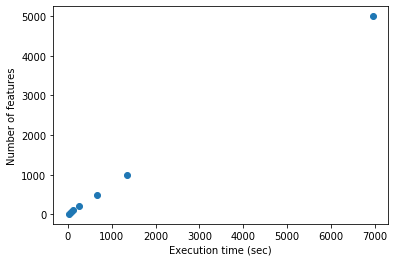

In [40]:
plt.scatter(execution_time, num_features_list)
plt.xlabel("Execution time (sec)")
plt.ylabel("Number of features")
plt.show()

In [27]:
'''
Sig_estimate: estimation of variance explained by each random effect and the residual sd
iteration_estimate[0, :] isn't this redundant information compared with Iteration_estimate?
Iteration_estimate: list of sigma estimates
exit_code: (0 is converged)
Score_list what is the score vector??? score = np.zeros(p + 1, dtype=np.float64)
Information_list: what is the information matrix?? Information = np.zeros((p + 1, p + 1), dtype=np.float64)
'''

print(len(results)) ### number of final models
print(results[0]) ### how one of the model results looks
convergence_status = [result[3] for result in results]
sum(Y.sum(axis=0) == 0) #### number of slipped genes

200
(array([0.00127801, 0.04977365, 0.26582646]), array([0.00102251, 0.04390242, 0.26585801]), array([[0.00102251, 0.04390242, 0.26585801],
       [0.001318  , 0.05037053, 0.26581885],
       [0.00127382, 0.04967957, 0.26582738],
       [0.00127801, 0.04977365, 0.26582646]]), 0)


10

In [28]:
### how exacly is the order of estimated sigmas for the REs? 
## is the first sigma for the first RE and then the residual RE is at last?
results[0][0]

array([0.00127801, 0.04977365, 0.26582646])

In [29]:
#### making a dict with gene names as keys and sigmas as the values 
sig_1_list = [a_model[0][0] for a_model in results]
{selected_features_name[i]: sig_1_list[i] for i in range(len(selected_features_name))}

sig_df = pd.DataFrame(list(zip(selected_features_name, sig_1_list)),
               columns =['genes', 'sig'])
sig_df = sig_df.sort_values(by='sig',axis=0,ascending=False)

sig_df.to_csv('sig_df.csv', encoding='utf-8', index=False)


In [ ]:
######### to do:
## time how long it takes for the models to be trained
## increase the number of features
## AM I RUNNING THIS CORRECTLY - HAMED?
### compare the results with lmer4
### what other info could you retrieve with lmer4 which you can not get now?

In [73]:
num_2vis = 50
df = sig_df['sig'].iloc[1:num_2vis]
df = df.rename(index=sig_df['genes'][1:num_2vis])

df.to_frame().style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})

,sig
Mt-co3,1018.592374
Ccl6,679.862269
Mt-co2,553.786757
Fth1,507.813811
C1qc,235.498204
Tf,220.213363
B2m,150.264439
Apoe,144.320098
Apoc3,74.863875
Ftl1,55.678573
